In [1]:
import h5py
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from IPython.display import clear_output
%matplotlib nbagg

In [2]:
lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)

filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))

background_from_fit = np.loadtxt('/sf/alvra/data/p18386/scratch/2020-10-20-10:45-psen-background.txt')

### Run next cell only once to make the directories for the SPECENC files.

In [20]:
path = '/sf/alvra/data/p18386/raw/'

folderlist = []
for file in glob.glob(path + 'ocp*'):
    folderlist.append(file)
folderlist = sorted(folderlist)

for folder in folderlist:
    print (folder.split('/')[-1])
#    os.mkdir('/das/work/p18/p18386/psen/specenc/' + folder.split('/')[-1])


ocp_10ps_32nJ_3-1
ocp_5_ph58_10ps
ocp_6_80nj_100ps_1-1_a
ocp_6_80nj_1500fs_1-1_a
ocp_6_80nj_1500fs_1-1_b
ocp_6_80nj_1500fs_1-1_c
ocp_6_80nj_300fs_1-1_a
ocp_6_80nj_300fs_1-1_b
ocp_6_noLaser_1
ocp_hd_pH58_no_plur_noLaser
ocp_hd_pH75_1-1_e_noLaser
ocp_hd_pH75_100ps_1-1_a
ocp_hd_pH75_100ps_1-1_b
ocp_hd_pH75_100ps_1-1_c
ocp_hd_pH75_100ps_1-1_d
ocp_hd_pH75_100ps_3-1_b
ocp_hd_pH75_10ps
ocp_hd_pH75_10ps_1-1_a
ocp_hd_pH75_10ps_1-1_b
ocp_hd_pH75_10ps_1-1_c
ocp_hd_pH75_10ps_1-1_d
ocp_hd_pH75_10ps_1-1_e
ocp_hd_pH75_1500fs_1-1
ocp_hd_pH75_1500fs_1-1_b
ocp_hd_pH75_1500fs_1-1_c
ocp_hd_pH75_1500fs_1-1_d
ocp_hd_pH75_1500fs_1-1_e
ocp_hd_pH75_1500fs_Laser_50Hz
ocp_hd_pH75_1500fs_Laser_50Hz_2
ocp_hd_pH75_300fs_1-1
ocp_hd_pH75_noLaser
ocp_hd_pH75_noLaser_2
ocp_hd_pH75_noLaser_5
ocp_hd_pH75_noLaser_d
ocp_hd_pH75_nolaser_3
ocp_hd_pH75_nolaser_4


In [3]:
# choose the data file(s):

datafiles = []
for file in glob.glob('/sf/alvra/data/p18386/raw/ocp_*/*.BSREAD.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)
datafiles

['/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001084.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001085.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001086.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001087.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001088.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001089.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001090.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001091.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001092.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001093.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001094.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001095.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001096.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10ps_32nJ_3-1/run_001097.BSREAD.h5',
 '/sf/alvra/data/p18386/raw/ocp_10

In [4]:
len(datafiles)

1074

In [6]:
print ('check folder name: {}'.format(datafiles[0].split('/')[-2]))

check folder name: ocp_10ps_32nJ_3-1


In [7]:
px2fs = 1.993008440575784 # new spectrometer, it is ~ 2 px to fs
p0 = 1024

for file in datafiles:
    clear_output(wait=True)
    print(file)
    
    with h5py.File(file, 'r') as f:
#        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
        pulse_ids = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/pulse_id'][:]
        
        stage_delay = f['/data/SLAAR11-LTIM01-EVR0:DUMMY_PV5_NBS/data'][0]  ## NBS PV, set to delay in fs from Delay Panel
     
        #stage_delay_mm = f['/data/SLAAR11-LMOT-M451:ENC_1_BS/data'][0]    ## Topas Delay in mm.
    #stage_delay = (stage_delay_mm - Timezero)*2/(3e8*1e3*1e-15)           ## convert Delay to fs, if loaded in mm
    
    edgePos = [] # edge positions in fs
    peakAmp = [] # xcorr amplitudes in arb. units
    pids = [] # pulse ids
    
    for k in range(0, len(pulse_ids)):
        pids.append(int(pulse_ids[k]))
        
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, 50)
        sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
        sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)
        
        peak2 = np.argmax(sig5gaussO1)
        
        edgePos.append((p0 - peak2)*px2fs)
        peakAmp.append(np.max(sig5gaussO1))
    
    folderName = file.split('/')[-2]
    runNumber = file.split('.')[0].split('/')[-1]
    
    savefile = '/das/work/p18/p18386/psen/specenc/' + folderName + '/' + runNumber + '.SPECENC.h5'
          
    hf = h5py.File(savefile, 'w')
    hf.create_dataset('pulse_ids', data=pids)
    hf.create_dataset('nominal_delay_from_stage', data=stage_delay)
    hf.create_dataset('arrival_times', data=edgePos)
    hf.create_dataset('arrival_times_amplitude', data=peakAmp)
    hf.close()
    print (savefile)

/sf/alvra/data/p18386/raw/ocp_hd_pH75_nolaser_4/run_007218.BSREAD.h5
/das/work/p18/p18386/psen/specenc/ocp_hd_pH75_nolaser_4/run_007218.SPECENC.h5


In [8]:
dataSpecEnc = []
for file in glob.glob('/das/work/p18/p18386/psen/specenc/ocp_6_80nj_300fs_1-1_a/*.SPECENC.h5'):
    #print (file)
    dataSpecEnc.append(file)
dataSpecEnc = sorted(dataSpecEnc)
dataSpecEnc
print (len(dataSpecEnc))

57


In [9]:
all_arrTimes = []

import itertools

for Specfile in dataSpecEnc:
    clear_output(wait=True)
    print (Specfile)
    with h5py.File(Specfile, 'r') as f:
        peakAmp = f['arrival_times_amplitude'][:]
        arrTimes = f['arrival_times'][:]
        delay_fs = f['nominal_delay_from_stage'][:]
        
        light_shots = peakAmp * 10000 > 10
        
        arrTimes_light = delay_fs + arrTimes[light_shots]
        
        print (len(arrTimes), len(arrTimes_light))
        
    all_arrTimes.append(arrTimes_light)
        
all_arrTimes = list(itertools.chain.from_iterable(all_arrTimes))
print ('Total loaded shots = {} from {} runs'.format(len(all_arrTimes), len(dataSpecEnc)))


/das/work/p18/p18386/psen/specenc/ocp_6_80nj_300fs_1-1_a/run_010230.SPECENC.h5
2113 1042
Total loaded shots = 264862 from 57 runs


<IPython.core.display.Javascript object>


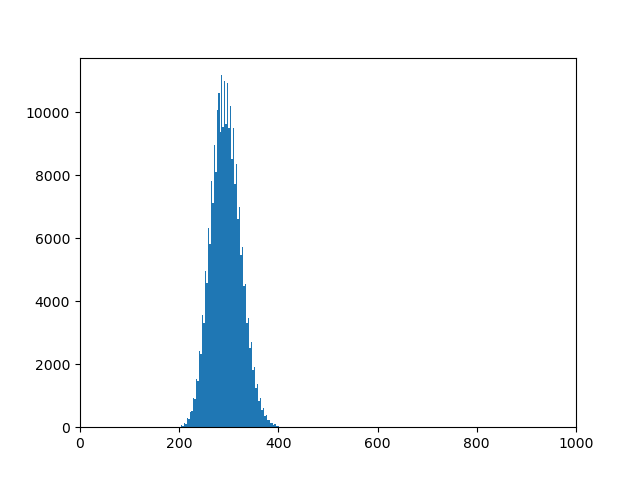

In [11]:
plt.figure()
plt.hist(all_arrTimes, bins =100)
plt.xlim(0,1000)
plt.show()

In [54]:
arrTimes

array([2073.11998013,    0.        ,    0.        , ..., 2135.1275568 ,
          0.        ,    0.        ])